# Clustering using single-cell RNA-seq data with UMAP, t-SNE and scVI

## Table of contents
1. [Introduction](#introduction)
2. [Datasets](#datasets)
3. [Prerequisites](#prerequisites)
4. [Uniform Manifold Approximation and Projection (UMAP)](#uMAP)
5. [T-distributed stochastic neighbor embedding (t-SNE)](#tSNE)
6. [Single-cell Variational Inference (scVI)](#scVI)
7. [Comparative Evaluation of Clustering Methods](#comparison)
    1. [Ease of Use](#ease)
    2. [Quality of Visualisation](#visualisation)
    3. [Sensitivity to Parameter Choice](#sensitivity)
    4. [Robustness of Algorithms](#robustness)
    5. [Speed of Execution and Scalability](#speed)

## Introduction <a name="introduction"></a>

Single cell RNA sequencing technologies developed as advances in sequencing technologies and microfluidics enabled measurement of gene expression in individual cells [(Eberwine et al., 2014)](https://www.nature.com/articles/nmeth.2769). Previously, researchers were only able to collect whole population-level data, but now techniques can dissociate heterogeneous tissues into single cell samples. These single cells can be individually sequenced, then read-aligned, to produce a matrix of data ($x_{ng}$) which includes counts for the expression of an individual gene ($g$) in each cell ($n$).

Using this scRNA-seq data, there are many available clustering algorithms available that can be applied, but here we focus on 3 key methods (UMAP, t-SNE, scVI). t-SNE is a popular method that appears to be a field-standard, and it was initially published in 2008. UMAP was released in early 2018 and is similar to t-SNE in that it provides quality visualisation. However, UMAP is argued to be a development on t-SNE due to its speed and ability to preserve a higher degree of the global structure. scVI is a comparatively recent method released in late 2018, and it significantly differs from UMAP and t-SNE by taking a probabilistic approach based on a hierarchical Bayesian model with conditional distributions specified by deep neural networks.

This tutorial assumes you will initially follow installation procedures for each of the 3 methods and will download all datasets directly; in order to run the methods, you will need to adjust the file references to match their new locations. After describing how each method works individually and comparing results produced to a 'gold standard' set of labels provided from the [original paper](https://www.nature.com/articles/s41586-018-0698-6), we compare the techniques in terms of sensitivity to parameter choice, robustness of algorithms, speed of execution and scalability. 

## Datasets <a name="datasets"></a>

ScRNA-seq datasets come in a variety of different formats based on the original protocol used (e.g. SmartSeq2, CELL-seq, Drop-seq). Here, we focus on data produced using SmartSeq2 and 10x Genomics methods. 

### 70,000 cells
[Original Paper (Teichmann et al., 2018)](https://www.nature.com/articles/s41586-018-0698-6)  
[Download Data (SmartSeq2)](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6678/)  
[Download Data (10x Genomics)](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6701/)

For our work with the 10X dataset, we were provided with a filtered version that removed  genes with very low expression (to produce a dataset with 64,734 cells and 14,562 genes). 

### 1.3 million cells 
[Download Data (10x Genomics)](https://community.10xgenomics.com/t5/10x-Blog/Our-1-3-million-single-cell-dataset-is-ready-to-download/ba-p/276)  

While we cannot handle this data in this tutorial due to hardware limitations, in some places we provide some sample code and recommendations for use.

## Prerequisites <a name="prerequisites"></a>

------

**Quick-start requirements**:
1. [Anaconda 3](https://www.anaconda.com/distribution/)
2. [Scanpy (v.1.4)](https://scanpy.readthedocs.io/en/latest/)
3. Access to OS command-line shell
4. Clone the [scVI GitHub repository](https://github.com/YosefLab/scVI) and run `setup.py` (current release: 0.2.4)
5. Download all datasets and move to the same folder as this notebook

-------

To run this tutorial, we recommended installing [Anaconda 3](https://www.anaconda.com/distribution/). It comes with many of the standard packages used for data science in Python, which includes most of the prerequisites for the packages we will be using. It also includes the Jupyter Notebook. Installation instructions can be found in the website linked above. Additional prerequisites are detailed in the respective sections of this tutorial.

Additionally, we recommend that you have at least cursory knowledge on how to use your operating system's command line shell. For those on UNIX-like systems (which includes macOS and Linux), you can access bash through the terminal app. For Windows users, you can use either cmd or PowerShell depending on what version of Windows you use. Python packages can be installed from these command line shells by using either the `conda install <package name>` or `pip install <package name>` commands. You may sometimes require administrator privileges to install the packages, in which case run them with `sudo <command>` for macOS and Linux, or run your shell as an administrator for Windows.

The easiest way we have found to run UMAP and t-SNE on single cell data sets is using [Scanpy (Single-Cell Analysis in Python)](https://scanpy.readthedocs.io/en/latest/). Scanpy can be installed using pip by running `pip install scanpy` in your command line shell.

For scVI, at the time of writing, the only way to install scVI is to clone the [GitHub repository](https://github.com/YosefLab/scVI) and run `setup.py`. While it is currently possible to install scVI using conda and pip, these install release 0.1.3, which has limited functionality relative to the current release 0.2.4. This has been reported via their GitHub issue tracker, and [correspondence](https://github.com/YosefLab/scVI/issues/266) with the original authors confirms this is a bug that will be resolved in the future.

Finally, to make things simpler, make sure your data files are located in the same folder as this notebook.

## uMAP <a name="uMAP"></a>


UMAP (Uniform Manifold Approximation and Projection) is an algorithm used for dimension reduction ([McInnes et al 2018](https://arxiv.org/pdf/1802.03426.pdf)). There are several different tools and algorithms that have been developed to undertake the task of dimension reduction which in the field of machine learning is the process of reducing the number of random variables being considered, resulting in a set of principal values which are of greater ease to analyse and visualise. t-SNE is one of the most popular techniques for dimensionality reduction and has been compared to UMAP which allegedly is significantly faster and provides better scaling. If true, this would allow for the same quality of embeddings to be generated from larger data-sets that other methods wouldn’t be able to achieve. The most notable example of the application of UMAP for modelling is the GoogleNews data-set, (consisting of 3 million word vectors) which was recorded to have been completed in roughly 200 minutes compared to multicoreTSNE, which took several days. 

In order to effectively compare the efficiency and accuracy of UMAP, several parameters crucial for the correct visualisation of data underwent extensive analysis.

#### Further reading

McInnes, L., Healy, J., Saul, N., and Großberger, L. (2018). UMAP: Uniform Manifold Approximation and Projection. Journal of Open Source Software 3, 861.
    Paper located at: https://arxiv.org/pdf/1802.03426.pdf

Introduction to ScanPY:
https://scanpy.readthedocs.io/en/latest/

ScanPY installation guide:
https://scanpy.readthedocs.io/en/latest/installation.html

AnnData Documentation:
https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData

### Initial Setup

In [1]:
# Import all prerequisites

import numpy as py
import pandas as pd
import scanpy as sc
import time  #all time functions are optional and were used for run-time analysis

### Functionality:
* `scanpy.pp`: The pre-processing module. Mainly used for neighbor analysis, however it has a bunch of other functionality, as well as functions for t-SNE
* `scanpy.tl`: The tools module. This contains the UMAP function (and t-SNE too.)
* `scanpy.pl`: The plotting module. This takes the data created through the pre-processing and tools modules to provide visualization of the data.

### Loading and reading through data: 
The data used in this tutorial was saved locally, so make sure you've downloaded and decompressed the relevant data sets and altered the code to account for location. The 10x data might be a bit big, so please ensure that you have a good amount of RAM to run it (more than 8GB recommended).

In [2]:
#Reading data
data_ss2=sc.read("SS2_raw_counts.csv")
data_10x=sc.read("decidua_data_10x_filtered.csv", cache=True, delimiter='\t')

The data sets used in our tutorial are transposed due to the fact that they contain genes as rows, whereas the algorithms expect cells as rows. Make sure your data is oriented correctly before transposing any of it. The data is loaded as AnnData (annotated data) objects, which contains the data as a matrix and several pandas dataframes which contain the metadata. More information about AnnData can be found here: https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData.
To allow UMAP to process the data we have correctly linked the labels, each of the cells will have to be loaded and matched to the right entry. Scanpy makes this process simpler through the use of pandas dataframes for annotations in AnnData objects.

In [6]:
meta_ss2 = pd.read_csv('E-MTAB-6687_arrayexpress_ss2_meta.txt', sep='\t')
meta_ss2.set_index('Cell', inplace=True)
data_ss2.obs['cluster'] = meta_ss2['final_cluster'].astype('category')

meta_10x = pd.read_csv('arrayexpress_10x_meta.txt', sep='\t')
meta_10x.set_index('Cell', inplace=True)
data_10x.obs['cluster'] = meta_10x['final_cluster'].astype('category')

#### Note about time.time()
If the user wishes to record the run-time of the pre-processing and UMAP, it is recomended that everything between the start time and end time be kept together. One note about `time.time()` is that it outputs the number of seconds since the epoch (January 1, 1970, 00:00:00)
#### Pre-processing
For the preprocessing, `pp.neighbors` has been used. Here the parameters of `n_neighbors` and `n_pcs` have been tested, however there are other parameters that can be tweaked. Information about how these parameters affect the final result can be found later in this tutorial.
#### UMAP Tool
For the actual clustering we use `sc.tl.umap(data)`. This is where the `min_dist`, `spread`, and `init_pos` parameters were tested, again there are more parameters that can be played around with. The results again will be detailed in the sensitivity to parameter choice section of the tutorial. Our recommended values for these parameters have been included, however these may be relative to your data sets and preferences.

In [ ]:
start = time.time() #Time can be removed if the user does not wish to track runtime
print (start)
sc.pp.neighbors(data) #Pre-processing
sc.tl.umap(data, min_dist=0.1, spread=3.5) #UMAP clustering tool
end = time.time()
print(end)
time_elapsed = end-start #Calculate elapsed time

#### Plotting
Finally plotting the data and printing the time needed to complete the process.

In [ ]:
sc.pl.umap(data,color='cluster')
print(time_elapsed) #Print time, in seconds

## t-SNE <a name="tSNE"></a>
t-SNE is the de-facto standard in visualizing high-dimensional data. A quick explanation on how it performs dimensionality reduction is that it creates a probability distribution (stochastic) to capture the relationships of the data points (neighbors) in the high dimensional space, and then tries to recreate it in a lower dimensional space (embed) using Student's t-distribution, hence the name (t-Distributed Stochastic Neighbor Embedding, t-SNE). For a deeper look into the algorithm and how it works, check out the following resources:
* https://lvdmaaten.github.io/tsne/
* https://distill.pub/2016/misread-tsne/
* https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/

The easiest way to run t-SNE on single cell data sets would be to use the [Scanpy (Single-Cell Analysis in Python)](https://scanpy.readthedocs.io/en/latest/) package, which can also run UMAP. Scanpy can be installed using pip by running `pip install scanpy` in your command line shell. Additionally, as t-SNE can be somewhat slow, it is recommended to install the fast t-SNE package using `pip install MulticoreTSNE`. If the installation fails, you may need to first install cmake (`pip install cmake`).

### Initial Setup

In [1]:
# Import all prerequisites (you can skip this block if you have run the UMAP tutorial)
import numpy as np
import pandas as pd
import scanpy as sc

Scanpy has 3 core modules:
* `pp`: The preprocessing module. We will mainly use this for reducing the number of principal components using PCA so that t-SNE does not take forever to run.
* `tl`: The tools module. This contains the t-SNE function (and UMAP too.)
* `pl`: The plotting module. This takes the data that has been processed by the tl module and creates a graph.

### Load the Data
For the purposes of this tutorial we will be loading the data from the local disk, so make sure you've downloaded and decompressed the data sets provided above before running the following block. The 10x data might be a bit big, so please ensure that you have a good amount of RAM to run it (more than 8GB recommended). If you have run the UMAP tutorial, you can skip this block.

In [2]:
# Caching is recommended for large files to allow for faster loading in the future.
data_ss2 = sc.read('SS2_raw_counts.csv', cache=True, delimiter=',')
data_ss2 = data_ss2.transpose()

data_10x = sc.read('decidua_data_10x_filtered.csv', cache=True, delimiter=',')
data_10x = data_10x.transpose()

The data sets are transposed in this case as they have genes as rows, whereas the algorithms expect cells as rows. Please make sure your data is the right way around before copying and pasting this code! The data themselves are loaded as `AnnData` objects, which contains the data as a matrix and several pandas dataframes which contain the metadata (more below). You can read more about it at https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData.

### Load and Attach the Metadata
To allow t-SNE to generate meaningful results, we will need to load the labels for each cells and match them to the right entry. Thankfully Scanpy makes this process painless by using pandas dataframes for annotations in `AnnData` objects. Again, if you have ran the UMAP tutorial, you can safely skip this block.

In [3]:
meta_ss2 = pd.read_csv('E-MTAB-6687_arrayexpress_ss2_meta.txt', sep='\t')
meta_ss2.set_index('Cell', inplace=True)
data_ss2.obs['cluster'] = meta_ss2['final_cluster'].astype('category')

meta_10x = pd.read_csv('arrayexpress_10x_meta.txt', sep='\t')
meta_10x.set_index('Cell', inplace=True)
data_10x.obs['cluster'] = meta_10x['final_cluster'].astype('category')

### Preprocess the Data
These data sets have thousands of features, which would make running t-SNE rather slow. We will first preprocess it with PCA to reduce it to a reasonable number of principal components. The resulting principal components will be written back into the `AnnData` objects without overwriting the raw data, which means we can redo it to try different numbers of principal components.

Scanpy allows you to specify the number of principal components to compute. More components tend to produce better results with t-SNE, but the improvement is marginal. Scanpy recommends 50 or less to be the target.

In [4]:
# n_comps specifies the number of principal components to compute
sc.pp.pca(data_ss2, n_comps=50)
sc.pp.pca(data_10x, n_comps=50)

### Run t-SNE and Plot
Next we actually perform the clustering. This process is rather straightforward, but there are a few hyperparameters that can be tuned to provide better results. A quick description of them are as of the following:
* `perplexity`: Defines how many points are considered neighbors by each point. Smaller values cause local structures to have a stronger influence, whereas large values emphasize the global structure. Larger data sets tend to want a higher perplexity, but t-SNE is relatively robust against changes in this parameter. The recommended value is usually between 5 to 50.
* `learning_rate`: How far the algorithm jumps in each iteration. A higher learning rate can help avoid being stuck in a local maximum.
* `random_state`: The initial random seed. It influences the orientation of the clusters at the end, but doesn't affect their composition and is therefore not very important except for reproducibility.

For a deeper look into what other parameters you can supply, see https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.tsne.html#scanpy.tl.tsne

CPU times: user 53.1 s, sys: 7.96 ms, total: 53.1 s
Wall time: 13.2 s


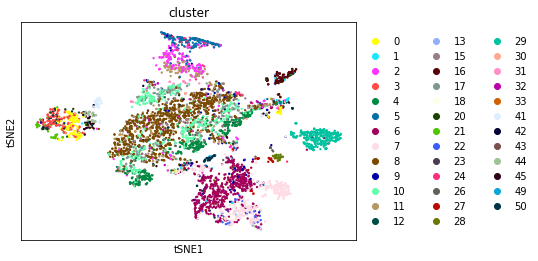

CPU times: user 16min 5s, sys: 224 ms, total: 16min 6s
Wall time: 4min 2s


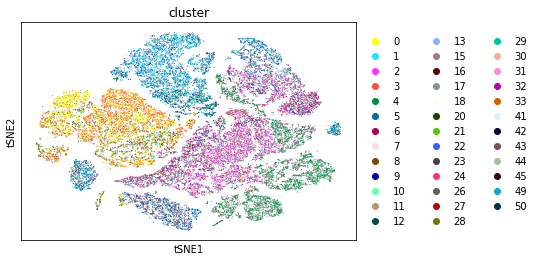

In [7]:
# Scanpy sets the default perplexity to 30, learning rate 1000, and random state 0
# n_jobs determines how many threads scanpy will use. Check the number of your CPU cores and adjust accordingly.
%time sc.tl.tsne(data_ss2, perplexity=30, learning_rate=1000, random_state=0, n_jobs=4)
sc.pl.tsne(data_ss2, color='cluster')

%time sc.tl.tsne(data_10x, perplexity=30, learning_rate=1000, random_state=0, n_jobs=4)
sc.pl.tsne(data_10x, color='cluster')

## Single-Cell Variational Inference (scVI) <a name="scVI"></a>

Single-cell variational inference (scVI) is an open framework for the probabilistic representation and analysis of gene expression in single cells. scVI is based on a hierarchical Bayesian model with conditional distributions specified by deep neural networks. It uses nonlinear transformation to encode high-dimensional data into a low-dimensional latent vector. This latent representation is then be decoded by another nonlinear transformation to generate a posterior estimate of distributional parameters (a zero-inflated negative binomial distribution). For a deeper look into the algorithm and how it works, check out the following resources:
* https://www.nature.com/articles/s41592-018-0230-9
* https://www.nature.com/articles/s41592-018-0229-2
* https://arxiv.org/pdf/1709.02082.pdf
* Source code: https://github.com/YosefLab/scVI

Using scVI in your computer requires [Python 3.6 or later](https://conda.io/en/latest/miniconda.html) and [PyTorch4](https://pytorch.org/) which is a popular Python-based deep learning programming toolkit compatible with high-speed graphical processing units (GPUs).

### Initial Setup

scVI itself is broken down into 3 core modules:

- `Dataset` allows data loading for four main formats (.h5ad, .csv, .loom, 10x), as well as providing support for 10 'built-in' datasets (see scVI data loading tutorial for examples). 
- `Models` includes the 3 core supported neural network & deep learning based models (VAE, VAEC, scANVI), as well a 1 model supporting use of VAE with integrated FISH data (VAEF). 
- `Inference` contains files that train a PyTorch model using the specified training data and monitors its statistics, and then draws inferences about the test data.

We have only imported the relevant components - see the GitHub repository for source code for loading other formats, using other models, and for alternative inference methods available with scVI.

In [2]:
# imports all required packages, including dataset loading tools as required.
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scvi.dataset import CsvDataset, Dataset10X, BrainLargeDataset
from scvi.models import VAE, VAEC, SCANVI
from scvi.inference import UnsupervisedTrainer

In [7]:
save_path = 'data/'
show_plot = True
n_epochs_all = None

### Loading a local CSV dataset ###
Here, we load the data from a locally stored dataset (SmartSeq2), which contains 5510 cells (rows) and 33693 genes (columns). scVI applies default downsampling of genes, which is useful as the scVI manuscript reports poor results when there are more genes than cells.

We use the optional arguments to specify a labels file, customised to contain an index column and the 'final_cluster' metadata, and also to change the number of downsampling of genes to a higher number. Alternatively, if you know the specific set of genes you would like to include, use subset_genes to specify a list of names.

In [44]:
# Loading a local .csv dataset.
local_csv_dataset = CsvDataset("SS2_raw_counts.csv", 
                               save_path=save_path, new_n_genes = 5000, labels_file = "labels_file.csv")

File data/SS2_raw_counts.csv already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 33693 to 5000 genes
Downsampling from 5510 to 5510 cells


### Setting Hyperparameters and Training the Model (CSV dataset)

For an initial example, we used the variational autoencoder (VAE) unsupervised model. One of our group with machine learning experience advised that a suitable starting training size would be around 75% training data, 25% test data.

In [46]:
# Setting hyperparamaters
n_epochs = 100
lr = 1e-3
use_batches = False
use_cuda = True

### Train using the VAE model and output model likelihood every 5 epochs
vae = VAE(local_csv_dataset.nb_genes, n_batch=local_csv_dataset.n_batches * use_batches, n_labels = 50, n_latent = 100)
trainer = UnsupervisedTrainer(vae,
                              local_csv_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 100/100 [14:47<00:00,  9.43s/it]


(0, 20000)

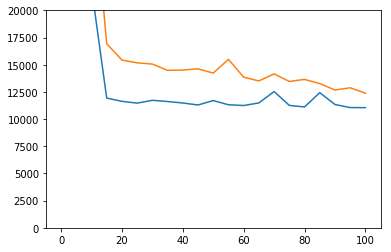

In [49]:
# Plotting the likelihood change across 100 training epochs - testing (orange) and training (blue) error.
# (Likelihood the model is trained incorrectly; likelihood data is incorrect.)

ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,100,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(0,20000)

Visualisation: we use a t-SNE space to represent high-dimensional clusters in a 2D-way, and applied labels from the 'final_cluster' metadata provided with the original dataset, to enable comparison to other methods.

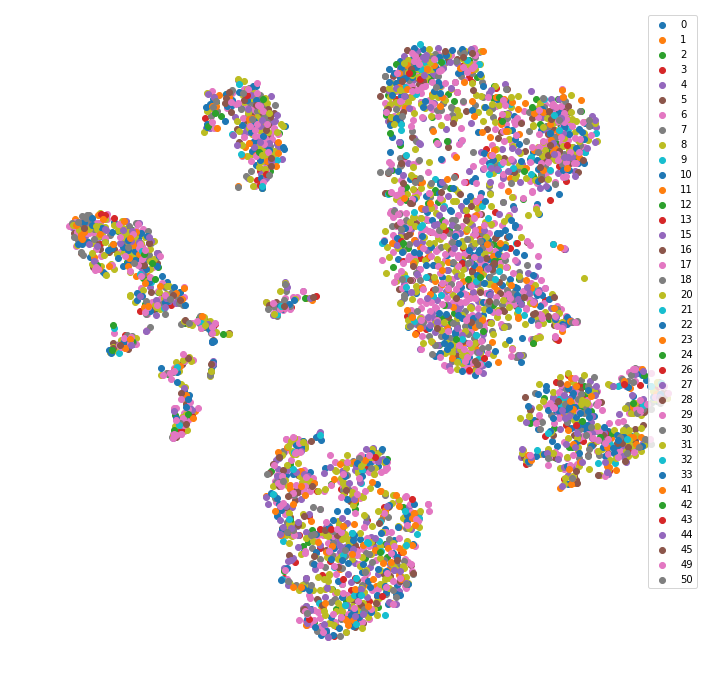

In [50]:
n_samples_tsne = 5500
trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

### Loading a local 10X genomics dataset ###
Here, we load the data from a locally stored 10X genomics dataset (including .tsv and .mtx files).    
* Examining the scvi.datasets.dataset10X.py source code does not identify any way in which we can provide metadata for labelling this data, and we could not find available examples for how this is done.  
* The specific files pre-implemented for datasets downloaded from the 10X genomics website use a .pickle metadata file, but there does not appear to be an option to provide this for local datasets.   

Therefore, the example we present is unlabelled with the final clusters from the Teichmann paper, and thus it will not be possible to directly compare these clustering results to the 'gold standard'. 

The dataset contains 64,734 cells and approximately 14,562 genes.

In [10]:
local_10X_dataset = Dataset10X('filtered_matrices', save_path=os.path.join(save_path, '10X_processedData/'), 
                               remote=False)

Preprocessing dataset
Finished preprocessing dataset


### Training the model (10X dataset)

Training this model using the full set of (c.14k) genes (without downsampling), and using hyperparameter settings similar to those provided in the scVI basic tutorial notebook (with a reduced number of epochs from 100 to 75), can lead to runtimes for training and visualisation in excess of 13 hours.

To remedy this in future, we recommend adding code for early stopping (during training), which you can find in the later runtime comparison sections for scVI in this notebook and commented out for the n_epochs line below.

In [12]:
# Setting hyperparameters
n_epochs = 75 # if n_epochs_all is None else n_epochs_all# with early stopping
lr = 0.01
use_batches = False
use_cuda = False # not applicable as we do not have an Nvidia GPU

In [13]:
# Train the VAE model and output model likelihood every 5 epochs
vae = VAE(local_10X_dataset.nb_genes, n_batch=local_10X_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              local_10X_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 75/75 [12:42:00<00:00, 339.55s/it]    


** Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

(0, 10000)

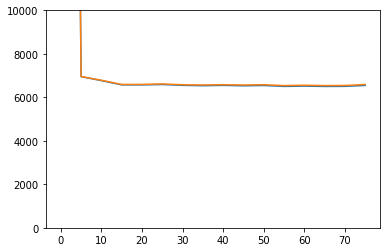

In [17]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,75,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(0,10000)

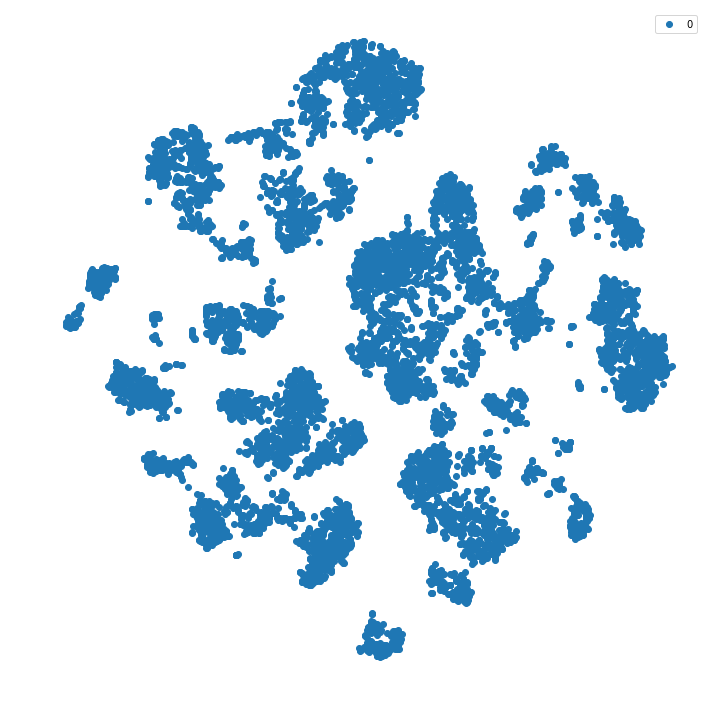

In [20]:
n_samples_tsne = 10000
trainer.train_set.show_t_sne(n_samples=n_samples_tsne, labels = local_10X_dataset.barcodes, color_by='labels')

We have represented a subsample of 10,000 cells in t-SNE as running it with the full complement of around 64,000 does not seem to return a result within a timeframe over which we have been able to leave it running (several hours).

While we cannot label this set and therefore cannot compare the clustering directly, we can see from the visualisation that there does appear to be a set of distinct cluster and regions into which the cell data is being separated by scVI.

### Loading large datasets (Brain-Large) 
For assessing the scalability of scVI. While we have not been able to test this directly as we lacked the computational resources to load the file (<font color='red'> which requires >32GB memory </font>), we include the relevant code below. 

`BrainLargeDataset` consists of 1.3 million mouse brain cells, spanning the cortex, hippocampus and subventricular zone, and profiled with 10x chromium. 

Reference: 10x genomics (2017). URL https://support.10xgenomics.com/single-cell-gene-expression/datasets. 

In [ ]:
# load dataset 
brainlarge_dataset = BrainLargeDataset(save_path=save_path)

Then proceed by training and visualizing the model, as in the example code below (please note that this code has not been tested).

In [ ]:
brainlarge_vae = VAE(brainlarge_dataset.nb_genes, n_batch=brainlarge_dataset.n_batches * use_batches) 
brainlarge_trainer = UnsupervisedTrainer(brainlarge_vae,
                                        brainlarge_dataset,
                                        train_size=0.75,
                                        use_cuda=use_cuda)
brainlarge_trainer.train(n_epochs=n_epochs, lr=lr)

In [ ]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,100,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(0,100000)

In [ ]:
n_samples_tsne = 100000
trainer.train_set.show_t_sne(n_samples=n_samples_tsne, labels = local_10X_dataset.barcodes, color_by='labels')

## Comparative Evaluation of Clustering Methods <a name="comparison"></a>

### Ease of use <a name="ease"></a>

#### Using UMAP
Using the package Scanpy, the implementation of UMAP for data visualisation was relatively simple resulting in a fast and effective method. Documentation for Scanpy was easy to follow meaning that the application of UMAP was not only efficient but also user friendly.

#### Using t-SNE
The Scanpy package makes both t-SNE and UMAP really easy to use. It additionally provides an online documentation that is both complete and easy to understand.

#### Using scVI
We found scVI very difficult to use and understand, and this significantly limited our ability to evaluate the claims made in the published literature and to benchmark the software against UMAP and t-SNE using our SmartSeq2 and 10X genomics datasets. 

[Documentation](https://scvi.readthedocs.io/en/master/) was available, and we also made use of the basic tutorial and data importation notebooks included in the scVI tests directory. However, as far as we can tell, some features of this tool are still under development. In the future, according to the [developers](https://github.com/YosefLab/scVI/issues/206) they are looking into supporting Scanpy, which we feel would open it to a greater range of users.

In general, we would not recommend using this method for clustering for the datasets included with this notebook. However, we expect that a user with a strong background in deep learning & neural networks, who has a dataset in a format that that is well-supported by the package (.h5ad, .loom, 10X genomics web data, default implemented 10X genomics datasets), might be able to achieve some of the impressive results reported in the published literature.

### Quality of Visualisation <a name="visualisation"></a>

When comparing UMAP to t-SNE, the visualization of the local properties is relatively similar with very minor discrepancies leading to most of the clusters being predominantly similar. For UMAP, the global properties could be arguably better, however this may be subjective, and highly dependant on the choice of parameters used. UMAP lacks the strong interpretability that other methods have, such as Principal Component Analysis and other related techniques such as Non Negative Matrix factorisation. However, when compared to t-SNE and scVI all methods are more ambiguous, they also allow for the analysis of larger data-sets faster, and produce information that could otherwise not be obtained from PCA. 

When comparing the graphs produced by the default parameters provided by the package used, at a glance UMAP produces denser clusters than t-SNE. However, cluster density can be altered by tweaking these parameters and therefore it shouldn't be used as a criteria to judge the quality of the visualisations.

One important thing to note about t-SNE is that it does not preserve distance, which means that the distances between the cluters in the visualisation aren't very meaningful. This is because it tends to expand dense regions and condense sparse regions.

As for the clusters themselves, both UMAP and t-SNE seems to end up with very similar clustering. UMAP seems to have more meaningful distance between clusters, however, and therefore may be argued to have a superior quality in that regard. Other studies also point out that UMAP better preserves continuity between cell types, which is a useful information for single cell analysis.

More on the comparison between t-SNE and UMAP in the following resources:
* https://www.nature.com/articles/nbt.4314
* https://arxiv.org/pdf/1802.03426.pdf


Compared with t-SNE and UMAP, scVI has poor performance in its quality of visualisation using these datasets. Some of these errors arise from the method itself - scVI has a variety of hyperparameters (such as train size, number of epochs of training) that we may want to be adjust to match the dataset instead of using default parameters. However, as the scVI package does not support to set these values automatically, we have to figure out good settings by watching the algorithm train. While Scanpy, the package we used for both t-SNE and UMAP, has an excellent manual that details how to prepare and run the data sets through it and providing advice on how to best use the parameters, scVI lacks this support at present. It is very possible that the poor visualisation was caused by a mistake in data preparation that we were unable to figure out.

### Sensitivity to Parameter Choice <a name="sensitivity"></a>

#### Hyperparameter variation with UMAP

Modification of parameters will alter aspects of processing and visualization. In total 5 parameters were investigated in order to provide sufficient evidence that parameter choice alters the performance of UMAP. All graphs were produced using the 10x data due to insufficient evidence that data size alters the sensitivity to parameter choice. 

CPU times: user 17.2 s, sys: 1.9 s, total: 19.1 s
Wall time: 12.7 s
CPU times: user 1min 34s, sys: 63.8 ms, total: 1min 34s
Wall time: 1min 7s


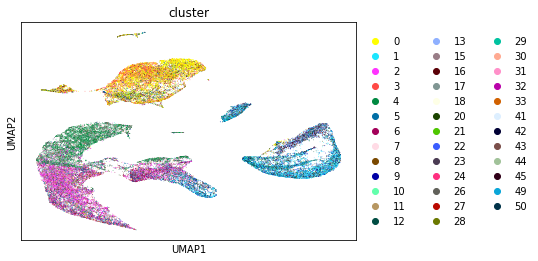

/home/ivan/anaconda3/envs/bio/lib/python3.7/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/ivan/anaconda3/envs/bio/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CPU times: user 1min 27s, sys: 67.3 ms, total: 1min 27s
Wall time: 1min


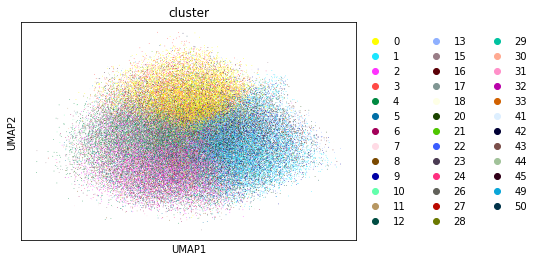

In [5]:
%time sc.pp.neighbors(data_10x) #Pre-processing
%time sc.tl.umap(data_10x, min_dist=0.1) #UMAP clustering tool
sc.pl.umap(data_10x, color='cluster')
%time sc.tl.umap(data_10x, min_dist=3.5)
sc.pl.umap(data_10x, color='cluster')

##### Minimum distance

The first graph was plotted with a minimum distance of 0.1 whilst a size of 3.5 was used for the bottom figure. By comparing the two together it is clear to see that a lower minimum distance is preferred as it provides a much clearer view of clustering within the dataset. This is due to the parameter controlling the distance between each data point, the higher the value the less clustered the outcome will be.

CPU times: user 17.1 s, sys: 1.95 s, total: 19 s
Wall time: 12.5 s


/home/ivan/anaconda3/envs/bio/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CPU times: user 1min 28s, sys: 87.8 ms, total: 1min 28s
Wall time: 1min 1s


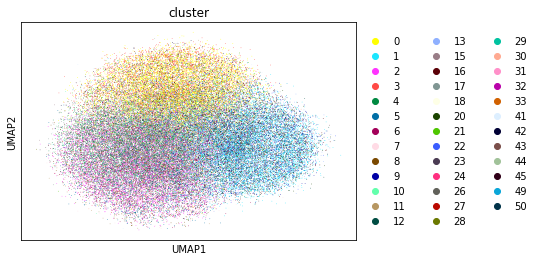

/home/ivan/anaconda3/envs/bio/lib/python3.7/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [ ]:
%time sc.pp.neighbors(data_10x)
%time sc.tl.umap(data_10x, spread=0.1)
sc.pl.umap(data_10x, color='cluster')
%time sc.tl.umap(data_10x, spread=3.5) #UMAP clustering tool
sc.pl.umap(data_10x, color='cluster')


##### Spread

For comparison of spread a size of 0.1 (top figure) and 3.5 was used (bottom figure). In this case a spread of 3.5 is favoured due to having a greater scale of embedding resulting in the clustering of the data. Unlike the minimum distance parameter, a higher value is preferred rather than a lower value. Both of these asssumptions are confirmed by the default parameters for UMAP, where minumum distance has a value of 0.1 and spread of 1.0.

In [ ]:
%time sc.pp.neighbors(data_10x, n_neighbors=2) #Pre-processing
%time sc.tl.umap(data_10x) #UMAP clustering tool
sc.pl.umap(data_10x, color='cluster')
%time sc.pp.neighbors(data_10x, n_neighbors=200)
%time sc.tl.umap(data_10x)
sc.pl.umap(data_10x, color='cluster')

##### N_Neighbours

The parameter `N_Neigbours` was analysed by using a value of 2 (top figure) and 200 (bottom figure). This characteristic determines the number of neighbouring data points, for visualisation of local data small values should be used, whilst for viewing global data larger integers should be implemented. From the figures produced it can be observed that global data provides a much more efficient method of cluster visualization.

In [ ]:
%time sc.pp.neighbors(data_10x, n_pcs=5) #Pre-processing
%time sc.tl.umap(data_10x, min_dist=0.1, spread=2.0) #UMAP clustering tool
sc.pl.umap(data_10x, color='cluster')

%time sc.pp.neighbors(data, n_pcs=10)
%time sc.tl.umap(data_10x, min_dist=0.1, spread=2.0)
sc.pl.umap(data_10x, color='cluster')

%time sc.pp.neighbors(data, n_pcs=20)
%time sc.tl.umap(data_10x, min_dist=0.1, spread=2.0)
sc.pl.umap(data_10x, color='cluster')

%time sc.pp.neighbors(data, n_pcs=50)
%time sc.tl.umap(data_10x, min_dist=0.1, spread=2.0)
sc.pl.umap(data_10x, color='cluster')

##### Number of principal components

The four figures above provide graphical representation of different values for the parameter `N_pc` which is utilised in the pre-processing phase to determine the number of primary components to be considered. For `N_pc = 5` the clusters are fewer and closer together, the shapes of the clusters are also different. The differences between the other three are not as exaggerated, and the patterns between the figures are mostly maintained. The main difference being that with 50 primary components the points are more compact. Depending on what is wanted from the data-set the `N_pc` of 20 is recommended as it preserves most of the structure, without clustering points too closely or having ambiguous clusters. 

In [ ]:
%time sc.pp.neighbors(data, n_pcs=20)
%time sc.tl.umap(data, min_dist=0.1, spread=2.0, init_pos='random')
sc.pl.umap(data,color='cluster')

%time sc.pp.neighbors(data, n_pcs=20)
%time sc.tl.umap(data, min_dist=0.1, spread=2.0, init_pos='spectral')
sc.pl.umap(data,color='cluster')

##### Initial position

The two figures above provide comparison of the parameter `init_pos`. The top graph was produced using the default initial position, `‘spectral’`, which provides a spectral embedding of the graph. This was compared to a graph in which the parameter was set at `‘random’` resulting in random initial embedding positions. In terms of clustering both graphs function adequately however it seems that there is a greater amount of cluster overlapping when `init_pos` is set to spectral which creates an unwanted trait.  

#### Hyperparameter variation with t-SNE
Summary: t-SNE is mostly sensitive to perplexity, though other parameters still have a lesser effect on the visualisation and execution time.  
For a detailed exploration of the effect of varying individual t-SNE hyperparameters, read the sections immediately below.

##### Number of Principal Components
Number of principal components do not seem to affect the time required to run t-SNE, however it affects the quality of the clustering. When it is set too low, the data points are overseparated. Setting it to a high number do not seem to have an adverse effect on visualisation quality, but takes more memory.

2 principal components
CPU times: user 17min 18s, sys: 450 ms, total: 17min 19s
Wall time: 4min 22s


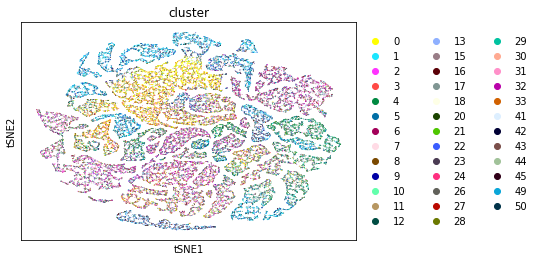

10 principal components
CPU times: user 16min 11s, sys: 132 ms, total: 16min 11s
Wall time: 4min 3s


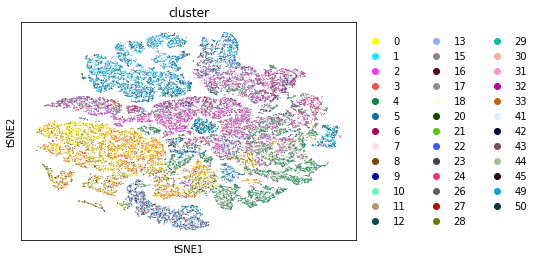

50 principal components
CPU times: user 15min 47s, sys: 268 ms, total: 15min 47s
Wall time: 3min 57s


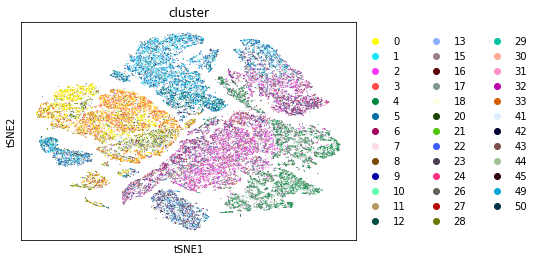

100 principal components
CPU times: user 15min 27s, sys: 136 ms, total: 15min 27s
Wall time: 3min 53s


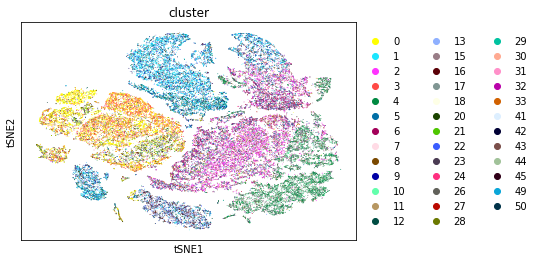

500 principal components
CPU times: user 16min 47s, sys: 432 ms, total: 16min 48s
Wall time: 4min 14s


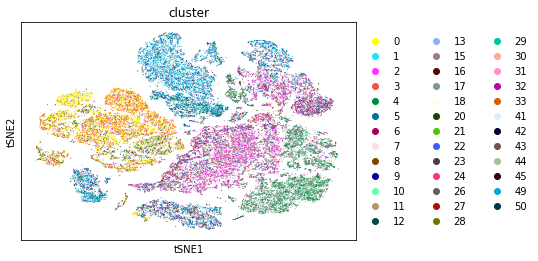

1000 principal components
CPU times: user 17min 44s, sys: 540 ms, total: 17min 44s
Wall time: 4min 29s


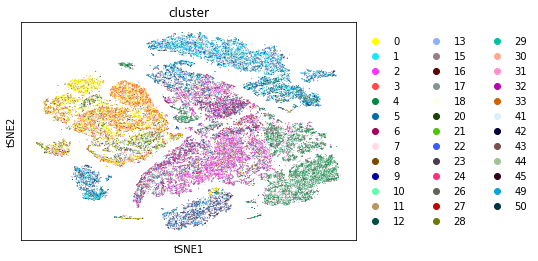

In [4]:
# Using 2 principal components is a known way to do sanity checks on your data.
n_comps_list = [2, 10, 50, 100, 500, 1000]
for n_comps in n_comps_list:
    print(str(n_comps) + ' principal components')
    sc.pp.pca(data_10x, n_comps=n_comps)
    %time sc.tl.tsne(data_10x, perplexity=30, learning_rate=1000, random_state=0, n_jobs=4)
    sc.pl.tsne(data_10x, color='cluster')

##### Perplexity
Perplexity determines how many neighbors are taken into account for each point. Smaller perplexities produce smaller clumps and show local relationships better, while larger perplexities capture the global properties better. When too small, however (<5) the clusters are too small to be meaningful as shown in the example above, while when too big (approaching a significant portion of the data points) it will tend to produce less meaningful results too as all the points try to be equidistant to each other. It is commonly suggested to have the perplexity set between 5 and 50, scaling proportionally with the size of your data.

Perplexity also affects execution time, with higher perplexity taking more time to run as each point will have to take more neighbors into account. Calculating higher perplexities also takes more memory. Interestingly, very low perplexities also take more time to run when compared to the recommended range of 5-50.

perplexity 1
CPU times: user 1min 47s, sys: 28 ms, total: 1min 47s
Wall time: 26.8 s


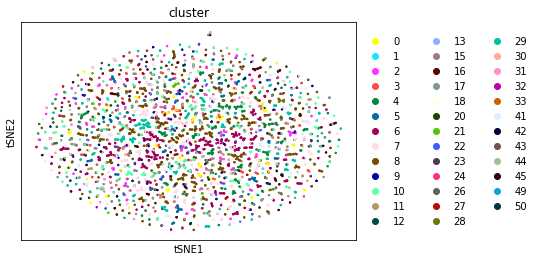

CPU times: user 20min 54s, sys: 2.16 s, total: 20min 57s
Wall time: 6min 39s


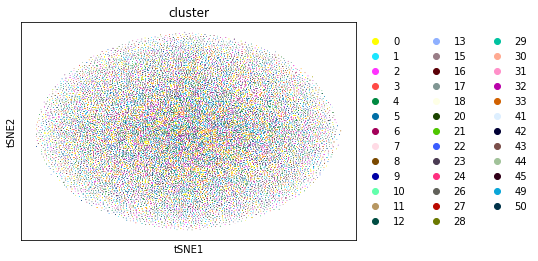

perplexity 5
CPU times: user 50.6 s, sys: 16 ms, total: 50.6 s
Wall time: 12.5 s


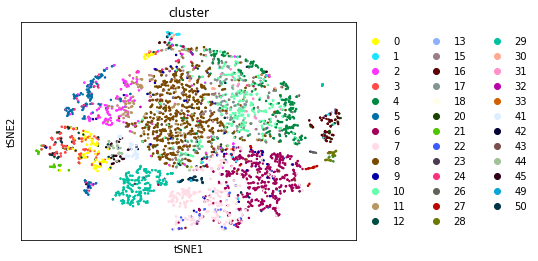

CPU times: user 14min 41s, sys: 40.1 ms, total: 14min 41s
Wall time: 3min 40s


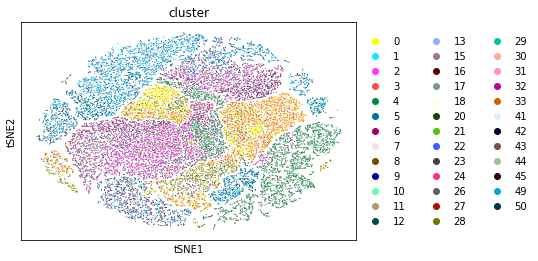

perplexity 50
CPU times: user 56.9 s, sys: 4.01 ms, total: 56.9 s
Wall time: 14.1 s


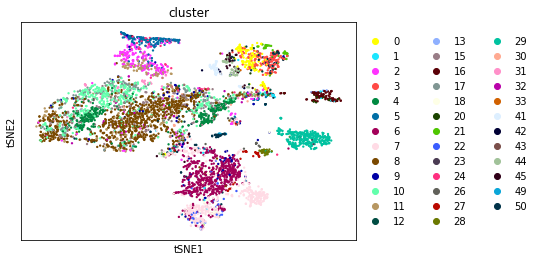

CPU times: user 16min 42s, sys: 284 ms, total: 16min 43s
Wall time: 4min 12s


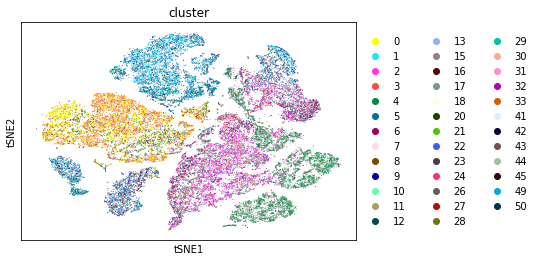

perplexity 100
CPU times: user 1min 10s, sys: 15.9 ms, total: 1min 10s
Wall time: 17.8 s


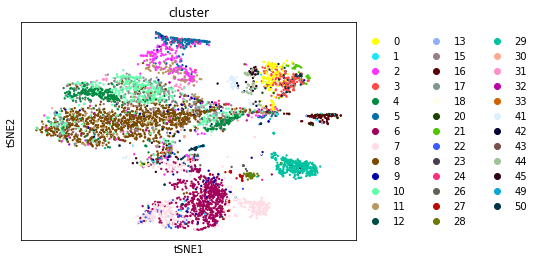

CPU times: user 20min 1s, sys: 380 ms, total: 20min 1s
Wall time: 5min 8s


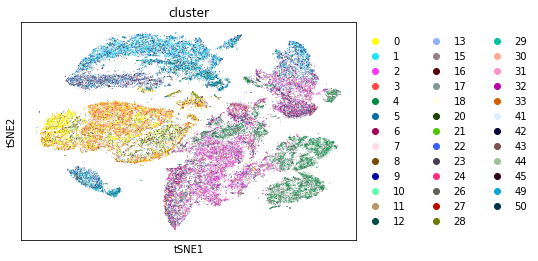

perplexity 1000
CPU times: user 4min 46s, sys: 228 ms, total: 4min 46s
Wall time: 1min 47s


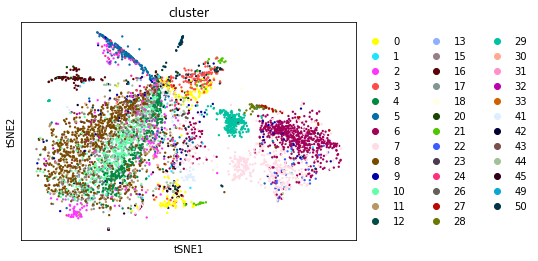

CPU times: user 1h 14min 47s, sys: 2.53 s, total: 1h 14min 50s
Wall time: 25min 58s


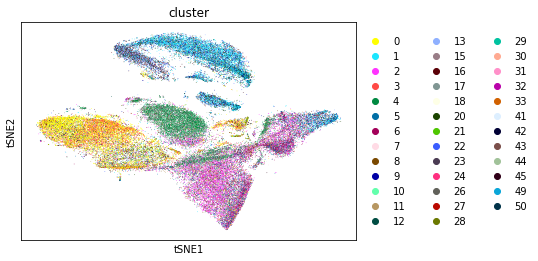

In [ ]:
perplexities = [1, 5, 50, 100, 1000]
sc.pp.pca(data_ss2, n_comps=50)
sc.pp.pca(data_10x, n_comps=50)
for perplexity in perplexities:
    print('perplexity ' + str(perplexity))
    %time sc.tl.tsne(data_ss2, perplexity=perplexity, learning_rate=1000, random_state=0, n_jobs=4)
    sc.pl.tsne(data_ss2, color='cluster')
    %time sc.tl.tsne(data_10x, perplexity=perplexity, learning_rate=1000, random_state=0, n_jobs=4)
    sc.pl.tsne(data_10x, color='cluster')

##### Learning Rate
Learning rate determines how far each step of the learning process will go. A sufficient amount is needed to reach a stable configuration by the end of the iteration step. When it is too low, the clusters will not be sufficiently separated. Setting it too high may cause some overshoot and produce outliers. Learning rate does not affect execution speed.

learning rate 1
CPU times: user 18min 50s, sys: 208 ms, total: 18min 50s
Wall time: 4min 44s


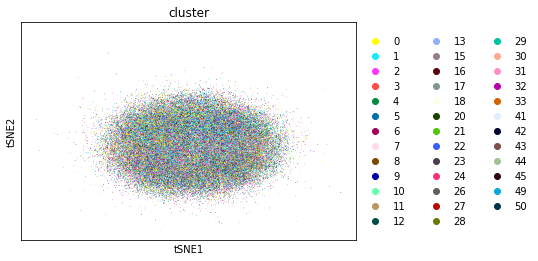

learning rate 10
CPU times: user 17min 33s, sys: 132 ms, total: 17min 33s
Wall time: 4min 24s


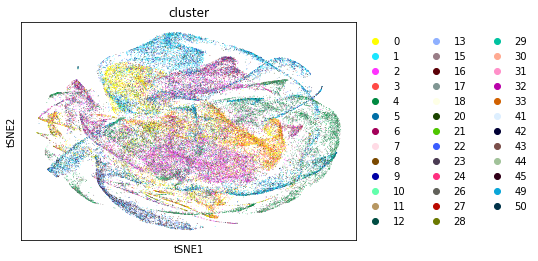

learning rate 100
CPU times: user 16min 27s, sys: 156 ms, total: 16min 27s
Wall time: 4min 7s


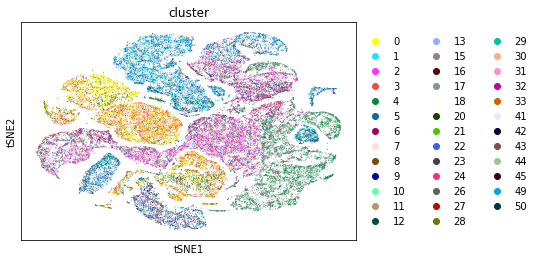

learning rate 500
CPU times: user 16min 11s, sys: 140 ms, total: 16min 11s
Wall time: 4min 3s


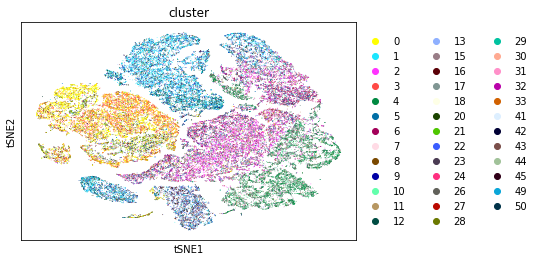

learning rate 1000
CPU times: user 15min 57s, sys: 160 ms, total: 15min 57s
Wall time: 4min


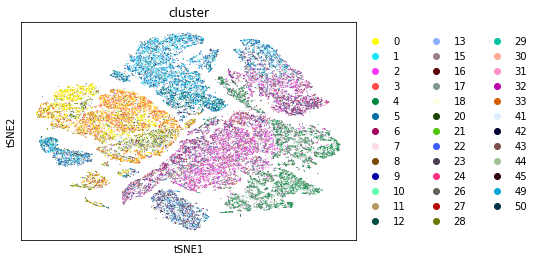

learning rate 5000
CPU times: user 15min 20s, sys: 104 ms, total: 15min 21s
Wall time: 3min 51s


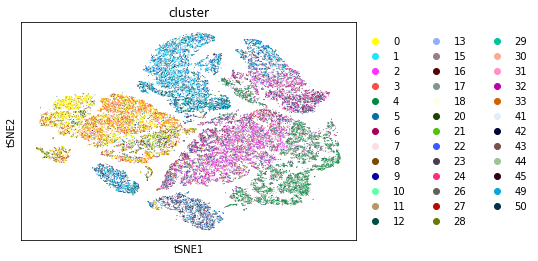

learning rate 10000
CPU times: user 15min 45s, sys: 136 ms, total: 15min 45s
Wall time: 3min 57s


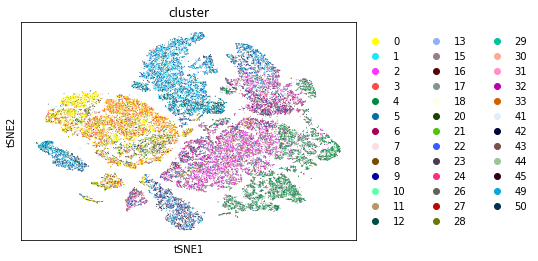

In [ ]:
rates = [1, 10, 100, 500, 1000, 5000, 10000]
sc.pp.pca(data_10x, n_comps=50)
for rate in rates:
    print('learning rate ' + str(rate))
    %time sc.tl.tsne(data_10x, perplexity=30, learning_rate=rate, random_state=0, n_jobs=4)
    sc.pl.tsne(data_10x, color='cluster')

##### Random State
Random state determines the initial seed. It only changes where the clusters end up on the plot, but not the compositions of the clusters, and therefore does not affect much. It can be used to try and generate a plot that is oriented nicely for interpretation. The results are more or less reproducible with minor differences given the same seed.

random state 0
CPU times: user 15min 49s, sys: 132 ms, total: 15min 50s
Wall time: 3min 58s


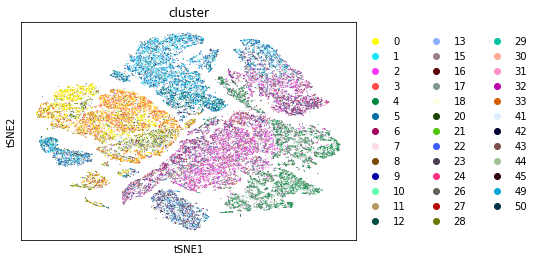

random state 1
CPU times: user 16min 10s, sys: 188 ms, total: 16min 10s
Wall time: 4min 3s


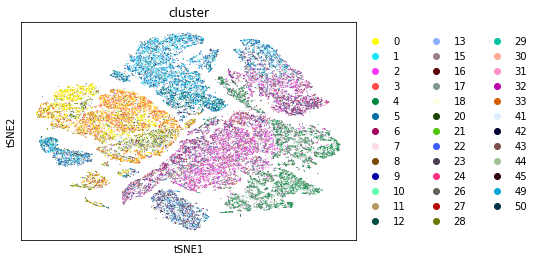

random state 2
CPU times: user 15min 50s, sys: 120 ms, total: 15min 50s
Wall time: 3min 58s


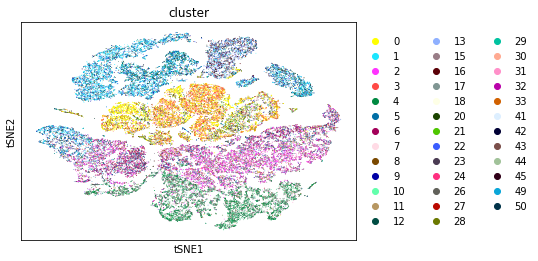

random state 10
CPU times: user 15min 38s, sys: 168 ms, total: 15min 38s
Wall time: 3min 55s


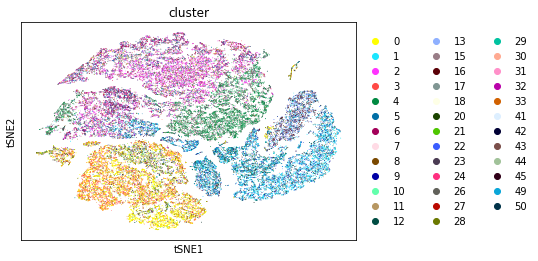

random state None


In [ ]:
# 0 is the default, None is random
rands = [0, 1, 2, 10, None]
sc.pp.pca(data_10x, n_comps=50)
for rand in rands:
    print('random state ' + str(rand))
    %time sc.tl.tsne(data_10x, perplexity=30, learning_rate=1000, random_state=rand, n_jobs=4)
    sc.pl.tsne(data_10x, color='cluster')

#### Hyperparameter variation with scVI

##### Variable hyperparameters and training models

When using scVI, there is a choice of 3 training models:
* Variational auto-encoder (VAE). (More information: http://pyro.ai/examples/vae.html).
* Variational auto-encoder with Classifier (VAEC) 
* Single-cell annotation using variational inference (scANVI). A semi-supervised Variational auto-encoder model - inspired from M1 + M2 model, as described in (https://arxiv.org/pdf/1406.5298.pdf).

Throughout this tutorial we have used VAE as our model as it is the only option providing unsupervised training (the alternatives are semi-supervised).

**Hyperparameters:**
* Cannot be learned from data when training the model (and thus need to be predefined).
* Define higher level concepts such as complexity, ability to learn, or training time.
* Are usually decided by retraining the model and evaluating final performance relating to either set of 'gold standard' data or through biological knowledge-based interpretation of results.

Hyperparameters we have identified that can be changed during training with scVI are:
* __n_epochs__: The maximum number of epochs over which the model is trained (integer argument). However, if the likelihood change falls below a set threshold, training will stop automatically if an 'early stop' is specified. 
* __lr__: Learning rate (floating-point argument)
* __use_batches__: Determines whether batch information is used in the training (boolean argument)
* __train_size__: proportion of the original dataset used for training (floating-point argument between 0 and 1)
* __n_latent__: dimension of the latent space
* __n_hidden__: number of nodes per hidden layer
* __n_layers__: number of layers used for encoder and decoder NNs
* __n_dropout__: dropout rate for neural networks

In order to compare hyperparameters with scVI, we have subsampled the number of genes using the SmartSeq2 dataset from c.14,000 to 1,000 - this is to reduce the overall runtimes. We have also run the dataset with larger samples but did not manage to produce meaningfully labelled results. We used this dataset as it is the one we were able to label using the original (50) final clusters. We focused on a subset of the possible hyperparameters to attempt to identify any that produced meaningful changes.

##### Varying the number of epochs

In [ ]:
# Loading a local .csv dataset.
local_csv_dataset = CsvDataset("SS2_raw_counts.csv", 
                               save_path=save_path, new_n_genes = 5000, labels_file = "labels_file.csv")

In [ ]:
# Setting hyperparameters
lr = 1e-3
use_batches = False
use_cuda = True
n_epochs = None
n_latent = 10

### Train using the VAE model and output model likelihood every 5 epochs
n_epochs_list = [100, 75, 50, 25]
for n_epochs in n_epochs_list: 
    vae = VAE(local_csv_dataset.nb_genes, n_batch=local_csv_dataset.n_batches * use_batches, n_labels = 50, n_latent=n_latent)
    trainer = UnsupervisedTrainer(vae,
                              local_csv_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
    trainer.train(n_epochs=n_epochs, lr=lr)

    n_samples_tsne = 5500
    trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

##### Varying the learning rate

In [ ]:
# Setting hyperparamaters
lr = 1e-3
use_batches = False
use_cuda = True
n_epochs = None

### Train using the VAE model and output model likelihood every 5 epochs
lr_list = [0.01, 0.001]
for lr in lr_list: 
    vae = VAE(local_csv_dataset.nb_genes, n_batch=local_csv_dataset.n_batches * use_batches, n_labels = 50, n_latent = 10)
    trainer = UnsupervisedTrainer(vae,
                              local_csv_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
    trainer.train(n_epochs=n_epochs, lr=lr)

    n_samples_tsne = 5500
    trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

##### Varying the train size

##### Varying the dimensions of latent space

### Robustness of Algorithms <a name="robustness"></a>


#### For UMAP
One very pertinent example of how robust UMAP can be seen during the pre-processing stage, in which it acknowledges that the datasets contain to many primary components to analyse. Subsequently, UMAP opts to run PCA (Principal Component Analysis) over the components to reduce them initially before they are subject to analysis. Even when considering values which are computationally intensive, UMAP doesn’t break as easily as expected.Within UMAP when any tool is incorrectly utilised the error it exits with informs the user that pre-processing (`pp.neighbours`) should be undertaken before and during the processing of any clusters. The system also informs the user if they’re trying to perform any analysis that may otherwise be incorrect, such as analysing more primary components than available during the pre-processing section. These errors serve more as warnings, trying to guide the user towards using the tools as optimally as possible. 

An example of a mathematical error found: `/Users/jamesbutterworth/anaconda3/lib/python3.7/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
return 1.0 / (1.0 + a * x ** (2 * b))`

This was created due to using exaggerated values for the `N_neighbours` parameter, however still ended in a successful run.

As UMAP samples larger amounts of data it is still able to discern a clearer structure, reducing the effect that noise would have on the dataset, however the robustness tends to waver when using small sample sizes of data which is noisy. The embedding tends to be extremely slow and inaccurate, however work is being done to improve the UMAP approach when it comes to smaller data-sets.

#### For t-SNE
t-SNE works well within the range of suggested parameters, but might produce less useful results when used with parameters outside of that range.

#### For scVI
scVI appeared to be highly robust in terms of generating at least some output in the final visualisation - we did not produce any errors that prevented execution of the methods (aside from prohibitively long runtimes when attempting to visualise large numbers of cells and occasional memory errors when loading very large datasets).  However, we were unable in any case to produce an output that we could verify as meaningful clusters, compared with the 'gold standard' labels.

### Speed of Execution and Scalability <a name="speed"></a>
For comparison, runtimes shown for UMAP and t-SNE were benchmarked on the same machine.

#### Speed of Execution with UMAP
Of all the algorithms analyzed, UMAP states that it is the fastest and most scalable, allowing for it to run on larger data-sets than other methods. The big O, a method used to describe the performance of an algorithm, has been estimated by the creator of UMAP (Leland McInnes) to be around $O(d*n^{1.14})$. These claims have been verified by observing the run-time of the algorithm on the data-sets as well as how much certain parameters may affect runtime. 

The scalability performance of UMAP and t-SNE was analysed by running the program with different exponentially increasing dataset sizes and timing how long UMAP took to calculate a neighborhood graph from the data. The datasets included 1000, 2000, 4000, 8000, 16000 and 32000 cells. As expected the amount of time to produce the neighbourhood graph increased as the amount of data escalated, for data sizes of 1000, 2000 and 4000 cells the length of time slowly increased however once a size of 8000 cells was reached the length of time increased by roughly 20-30 seconds. It should be noted that these measurements vary depending on the computer being used.

The alteration of parameters can create divergences in time taken to run. This can be observed when the number of `N_neighbours` is increased, when using a value of 2, UMAP will generate a graph in a shorter amount of time than when a larger value such as 200 is used, this is caused by the vast increase in neighbouring data points. When testing other parameters such as those mentioned above, no instance of time variation was observed suggesting that UMAP provides an efficient method of cluster visualisation.

Number of cells in dataset = 1000
CPU times: user 4.96 s, sys: 46.6 ms, total: 5.01 s
Wall time: 3.33 s
CPU times: user 2.62 s, sys: 8.25 ms, total: 2.63 s
Wall time: 2.64 s


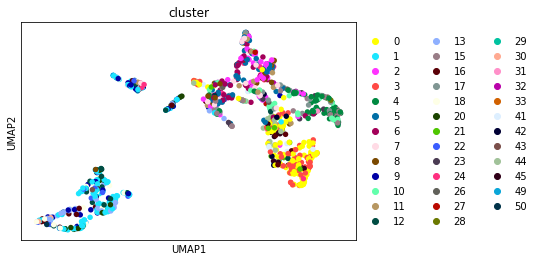

Number of cells in dataset = 2000
CPU times: user 2.19 s, sys: 12.4 ms, total: 2.21 s
Wall time: 409 ms
CPU times: user 3.59 s, sys: 3.97 ms, total: 3.59 s
Wall time: 3.59 s


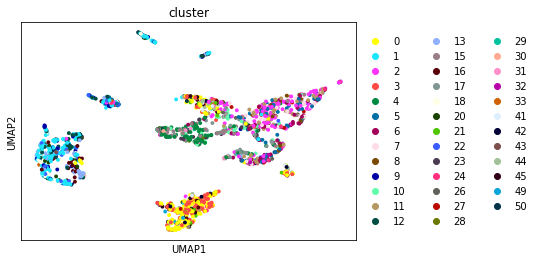

Number of cells in dataset = 4000
CPU times: user 3.25 s, sys: 45.7 ms, total: 3.3 s
Wall time: 881 ms
CPU times: user 8.12 s, sys: 11.6 ms, total: 8.13 s
Wall time: 8.12 s


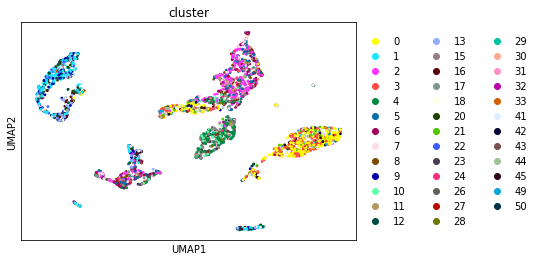

Number of cells in dataset = 8000
CPU times: user 4.96 s, sys: 151 ms, total: 5.11 s
Wall time: 2.35 s
CPU times: user 14.9 s, sys: 15.6 ms, total: 14.9 s
Wall time: 14.8 s


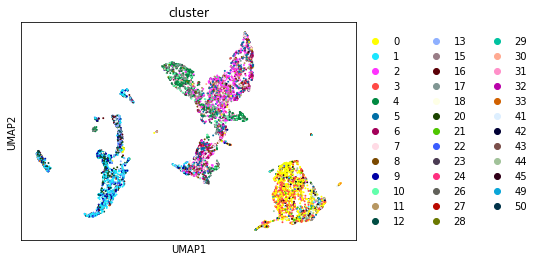

Number of cells in dataset = 16000
CPU times: user 9.5 s, sys: 54.8 ms, total: 9.56 s
Wall time: 6.72 s
CPU times: user 13.2 s, sys: 16.3 ms, total: 13.3 s
Wall time: 12.6 s


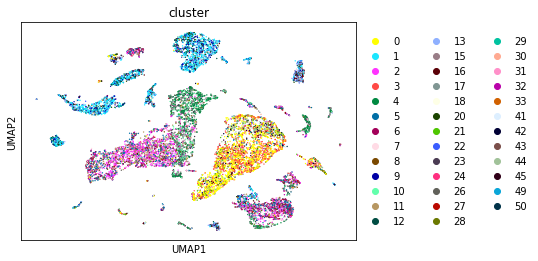

Number of cells in dataset = 32000
CPU times: user 12.8 s, sys: 191 ms, total: 13 s
Wall time: 8.86 s
CPU times: user 27.5 s, sys: 11.5 ms, total: 27.5 s
Wall time: 26.2 s


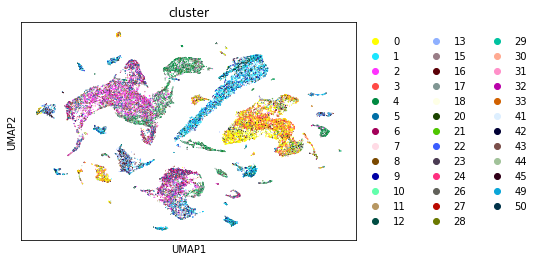

In [4]:
for exp in range(0, 6):
    n_obs = 2 ** exp * 1000
    print('Number of cells in dataset = ' + str(n_obs))
    sub = sc.pp.subsample(data_10x, n_obs=n_obs, copy=True)
    sc.pp.pca(sub, n_comps=50)
    %time sc.pp.neighbors(sub)
    %time sc.tl.umap(sub, min_dist=0.1, spread=2.0, init_pos='random')  
    sc.pl.umap(sub, color='cluster')

#### Speed of Execution with t-SNE
If you execute the code below, you can see that t-SNE scales in a close to linear fashion to the number of data points, provided the same hyperparameters. Barnes-Hut t-SNE, the implementation used here, actually has a time complexity of $O(n \times log(n))$, which is not as good as UMAP. Hyperparameter choices can have a significant effect on execution speed.

n_obs = 1000
CPU times: user 8.98 s, sys: 11.2 ms, total: 8.99 s
Wall time: 2.29 s


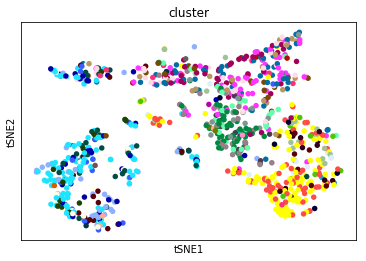

n_obs = 2000
CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 4.42 s


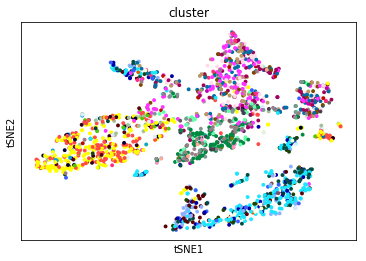

n_obs = 4000
CPU times: user 37.1 s, sys: 6.07 ms, total: 37.1 s
Wall time: 9.21 s


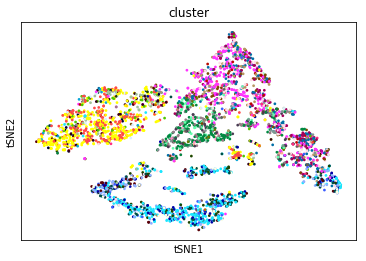

n_obs = 8000
CPU times: user 1min 22s, sys: 7.36 ms, total: 1min 22s
Wall time: 20.5 s


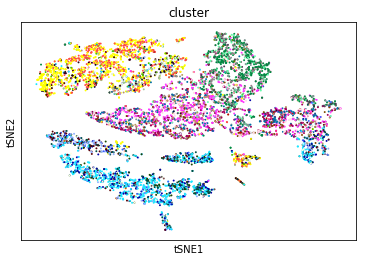

n_obs = 16000
CPU times: user 3min 19s, sys: 13.7 ms, total: 3min 19s
Wall time: 49.7 s


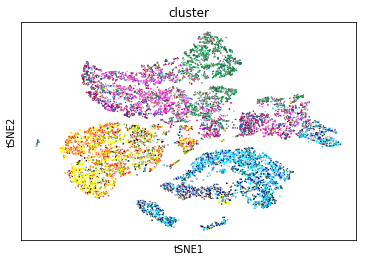

n_obs = 32000
CPU times: user 8min 4s, sys: 106 ms, total: 8min 4s
Wall time: 2min 1s


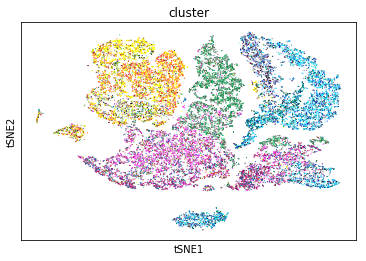

In [5]:
for exp in range(0, 6):
    n_obs = 2 ** exp * 1000
    print('n_obs = ' + str(n_obs))
    sub = sc.pp.subsample(data_10x, n_obs=n_obs, copy=True)
    sc.pp.pca(sub, n_comps=50)
    %time sc.tl.tsne(sub, perplexity=30, learning_rate=1000, random_state=0, n_jobs=4)
    sc.pl.tsne(sub, color='cluster', legend_loc=0)

#### Speed of Execution with scVI

scVI uses an unsupervised trainer, which makes it quite different from UMAP and tSNE and increases the overall runtime. In order to benchmark runtime, we import the 10X genomics dataset (as it is larger), and standardise the hyperparameters.

For comparison, all runtimes shown below were benchmarked on the same machine (MacBook Pro, processor 3.1 GHz Intel Core i7, GPU Intel Iris Graphics 6100 1.5 GB).

We found that runtimes would be very, very large if the number of genes was not subsampled down quite substantially from our initial 14,000 genes to 1,000 or less. Runtime analysis using large datasets in the original scVI paper used a subsample of 720 genes. Therefore our results below are presented for a subsample of 1000 genes. We have not included here the additional time taken for visualisation using tSNE, as this is also highly variable based on the number of samples that are chosen to display (from a few seconds for <1000 cells, to many hours for 50k+ cells).

In [9]:
# importing local 10X dataset
local_10X_dataset = Dataset10X('filtered_matrices', save_path=os.path.join(save_path, '10X_processedData/'), 
                               remote=False)

Preprocessing dataset
Finished preprocessing dataset


In [10]:
# Setting hyperparameters
n_epochs= 75 if n_epochs_all is None else n_epochs_all# with early stopping
use_batches = False
use_cuda = False
n_latent = 10
lr = 0.001

n_cells_list = [32000, 16000, 8000, 4000, 2000, 1000]
local_10X_dataset.subsample_genes(1000)
for n_cells in n_cells_list: 
    print(n_cells, " cells") 
    local_10X_dataset.subsample_cells(n_cells)
    
    vae = VAE(local_10X_dataset.nb_genes, n_batch=local_10X_dataset.n_batches * use_batches)
    trainer = UnsupervisedTrainer(vae,
                              local_10X_dataset,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
    %time trainer.train(n_epochs=n_epochs, lr=lr)

Downsampling from 14562 to 1000 genes
Downsampling from 64734 to 64734 cells
32000  cells
Downsampling from 64734 to 32000 cells
training: 100%|██████████| 75/75 [16:37<00:00, 14.19s/it]
CPU times: user 39min 28s, sys: 2min, total: 41min 28s
Wall time: 16min 42s
16000  cells
Downsampling from 32000 to 16000 cells
training: 100%|██████████| 75/75 [08:20<00:00,  9.54s/it]
CPU times: user 19min 44s, sys: 58.5 s, total: 20min 43s
Wall time: 8min 23s
8000  cells
Downsampling from 16000 to 8000 cells
training: 100%|██████████| 75/75 [04:34<00:00,  5.95s/it]
CPU times: user 9min 44s, sys: 35.9 s, total: 10min 20s
Wall time: 4min 37s
4000  cells
Downsampling from 8000 to 4000 cells
training: 100%|██████████| 75/75 [02:38<00:00,  1.76s/it]
CPU times: user 4min 49s, sys: 15.6 s, total: 5min 4s
Wall time: 2min 40s
2000  cells
Downsampling from 4000 to 2000 cells
training: 100%|██████████| 75/75 [01:11<00:00,  1.02s/it]
CPU times: user 2min 28s, sys: 9.34 s, total: 2min 38s
Wall time: 1min 12s
100

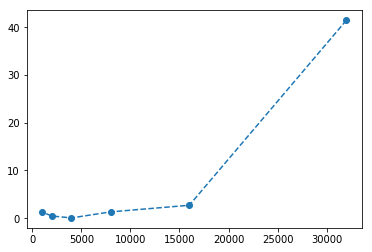

In [13]:
# change `time` with the results from the cell above in ``XXmin XXs`` format 
time = "41min 28s, 20min 43s, 10min 20s, 05min 4s, 02min 28s, 1min 18s" 
time = [float(x[:2]) + float(x[6:-1]) / 60. for x in str(time).split(",")]

plt.plot(n_cells_list, time, label="scVI", marker='o', linestyle='--')

In the [original paper](https://www.nature.com/articles/s41592-018-0229-2), it is claimed that scVI has scalability for up to 1 million cells, where the number of genes is limited to 720 (or fewer). They also implemented an 'early stopping' option to enhance speed while reducing runtime. 
We provide code below that could be used to test the reproducibility of these claims using the 1.3 million cell dataset (but please note that this code is untested due to hardware limitations).

In [ ]:
# load 1.3 million cell dataset
brainlarge_dataset = BrainLargeDataset(save_path=save_path)

# set hyperparameters 
n_epochs= 125 if n_epochs_all is None else n_epochs_all# with early stopping
lr=0.001
use_batches=False
use_cuda=True
n_latent = 10

# define a list of total cell numbers to subsample, train model, and report time taken
n_cells_list = [1000000, 500000, 100000, 50000, 30000, 15000]
for n_cells in n_cells_list: 
    print(n_cells, " cells") 
    brainlarge_dataset.subsample_cells(n_cells)
    
    brainlarge_vae = VAE(brainlarge_dataset.nb_genes, n_batch=brainlarge_dataset.n_batches * use_batches) 
    brainlarge_trainer = UnsupervisedTrainer(brainlarge_vae,
                                           brainlarge_dataset,
                                           train_size=0.75,
                                           use_cuda=use_cuda)
    %time brainlarge_trainer.train(n_epochs=n_epochs, lr=lr)